# Boosting Python


## Introduction

Python has plenty of appeal to the programming community: it's simple, interactive and free. But Fortran, C, C++ dominate high-performance programming. Why? Python is *slow*. There are two major reasons for that: **Python is a dynamically typed language** and **Python is an interpreted language**.

It doesn't make Python *a bad* programming language. On the contrary, Python is a great tool for various tasks that do not require running expensive simulations (web-development, scripting). Python also dominates the data-science due to availability of packages such as NumPy, SciPy and versatile machine learning tools (e.g. scikit-learn or TensorFlow).

As we discussed earlier, NumPy and SciPy integrate optimized and precompiled C code into Python and, therefore, might provide a significant speed up. But we have already encountered situations when it was not possible to avoid running Python loops that easily end up being painfully slow.

In this notebook we are going to discuss tools designed to provide C-like performance to Python code: *Cython* and *Numba*. What are they, what are they good for and why people still use C/C++ with much more complicated syntax?

## Interpreters VS compilers

Before we can precisely understand what are Cython and Numba, let's discuss the basics of compilers and interpreters.

A common mistake when understanding compilers is to think that the output of the compiler is necessarily [*machine code*][1] - code written in a low-level programming language that is used to directly manipulate the central processing unit (CPU). In fact, a *compiler* is a program that *translates* a source code written in a certain programming language into any other programming language (normally lower-lever). An *interpreter* is also a computer program. It executes the source code without translating it into the machine code. *But this doesn't make compilation and interpretation mutually exclusive:*

> [...most interpreting systems also perform some translation work, just like compilers][2].

Let's take the example of CPython. CPython is the default implementation of Python and is a [bytecode interpreter][3]. At the intermediate stage it compiles the source code into the lower-level language called bytecode, or p-code (portable code). Bytecode is universal to all platforms, or platform-independent. There is no further compilation of the bytecode into the machine code. Bytecode is executed *at runtime* by the so-called Python Virtual Machine (PVM) and CPython provides a C implementation of this virtual machine. When virtual machines, or p-code machines, are explained, it is often said that p-code can be viewed as machine code for a *hypothetical* CPU. Virtual machines, unlike real CPUs, are implemented as part of an interpreter program and not in the hardware of the platform.

Whenever you hear that "interpreters are slower than compilers", you must have in mind that it is not just a generic translator program that is meant by compiler in that context. CPython performs the compilation itself, as we know. The compilers meant in this context are the programs that translate the source code into machine code. Why are interpreters slower? The fact that p-code is *interpreted* and *executed* by the interpreter *at runtime* is partially the answer, but we still have to understand what compiler systems do.

There are two types of compilers: *ahead-of-time* (AOT) compilers and *just-in-time* (JIT) compilers.

> [AOT compilation][4] is the act of compiling a higher-level programming language into a native (system-dependent) machine code so that the resulting binary file can be executed natively.

In this way, the code executed at runtime produces the behaviour that has been predefined at compile time. On the other hand, the interpreter must both define and produce the desired behaviour at runtime by performing a statement-by-statement analysis. But note that:

> [It generally takes longer][2] to run a program under an interpreter than to run the compiled code but it can take less time to interpret it than the total time required to compile and run it.

What about the JIT compilers then? First of all,

> [JIT compilation][5] ... is a way of executing computer code that involves compilation during execution of a program – at runtime – rather than before execution.

Following the logic used to explain speed gain for AOT compilers versus interpreters, you might wonder: how can a JIT compiler be faster if it also defines the desired behaviour at runtime? There is good example that could explain the difference in performance between typical interpreter and JIT compiler. Suppose the source code contains a loop that has to be executed $n$ times. An interpreter will have to analyze the bytecode statement-by-statement at each iteration. A well-implemented JIT compiler will produce the translation into the machine code, which is the most computationally expensive operation, only once.

How JIT compilers compare to AOT compilers is a somewhat more sophisticated discussion that we won't enter but you are free to investigate this question on your own.

[1]: <https://en.wikipedia.org/wiki/Machine_code> "Machine code"
[2]: <https://en.wikipedia.org/wiki/Interpreter_(computing)> "Interpreter"
[3]: <https://en.wikipedia.org/wiki/Interpreter_(computing)#Bytecode_interpreters> "Bytecode interpreters"
[4]: <https://en.wikipedia.org/wiki/Ahead-of-time_compilation> "AOT compilation"
[5]: <https://en.wikipedia.org/wiki/Just-in-time_compilation> "JIT compilation"

## Cython and Numba: what, when and how?

We are now well-equipped to discuss Cython and Numba. What are they? 

*Cython* is a *compiled programming language* itself. It aims to run at C-like speed using Python-like syntax. If well designed, Cython code speeds up the program by several order(s) of magnitude in comparison to its Python analogue.

*Numba* is a *JIT compiler*. It translates Python source code into the machine code using the open source [LLVM compiler][6] written in C++.

Cython and Numba generally show similar performance for the same kinds of problems but each of them might fit better in certain situations.

Cython has the advantage of being very flexible meaning that normally any Python code can be rewritten in Cython without global rethinking of the original logic.

The major "disadvantage" of Cython is that it obviously requires some programming effort to "translate" the Python code into Cython. It is said, though, that for the Python programmer it must take relatively insignificant effort to learn Cython. Being a compiled language, Cython also requires compilation instructions to be provided - so-called Makefiles. Python's Makefiles are usually named `setup.py`. As they are simply Python modules, they do not require a lot of extra knowledge for Python programmers.

Even though it has been said that Cython does not require enormous effort from the Python programmer, Numba is an absolute winner when it comes to simplicity of implementation. It very often does not require anything but a simple Python decorator applied on a Python function. *A Python decorator is a tool provided in standard python distribution and will be explained further in this notebook.*

The disadvantage of Numba is interconnected with what we have called its advantage. While being very simple to use, it comes with [certain limitations, such as][7]:

* Not compiling the whole program but only the Python function;
* Not integrating well with some Python packages (such as Pandas);
* Providing limited support to some types of data (such as strings);
* Not integrating as efficiently as Cython with C and C++.

In some cases it might be quite a challenge to use Numba in your program, as it will require radical changes to the source code.

Cython and Numba are powerful tools. They have their "downsides", which does not mean that one is to be *always* chosen over the other. The programmer must always have his mind open and decisions balanced. Whenever you have troubles explaining your designing decisions, it usually means that they must be questioned.

For the problems considered in this course, Numba suffices. Nevertheless, we further demonstrate how to use both Cython and Numba. Let us first define the model problem. In the previous notebook you were introduced to the Gauss-Seidel method. We have implemented the numerical solver using Python loops and saw considerable slow down in comparison with the Jacobi solver. We will further show how this code can be sped up using both Cython and Numba.

But before we introduce the Python tool that Numba strongly relies on - *Python decorators*.

[6]: <https://en.wikipedia.org/wiki/LLVM> "LLVM"
[7]: <https://christinakouridi.blog/2019/12/29/intro-numba/> "Limitations of Numba"

### Python decorators

So called wrapper functions are widely used in various programming languages. They take a function or a method as a parameter and extend its behaviour. Wrapper functions usually intend to *abstract* the code. They, therefore, might shorten and simplify it *by a lot*. Python decorators are unique to Python - they are basically shortcuts (syntactic sugars) for calling a wrapper function. Consider the implementation of a sample decorator function:

In [1]:
def decorator(func):
    def wrapper(*args, **kwargs):
        print('Preprocessing...')
        
        res = func(*args, **kwargs)
        
        print('Postprocessing...')
        
        return res
    return wrapper

*Note* that the choice of names `decorator` and `wrapper` is not restricted in any way in Python. Whatever is allowed for regular Python functions is also allowed for the names of decorating and wrapping functions.

This decorator does nothing but simply prints something before and after the internal function is called. We propose you to view it as an abstraction for some computations. Note that a decorator function returns *a function*. When decorating functions, you will ultimately want to normally return what the internal function returns *but* also perform certain computations before and after it executes.

If we proceed without using Python decorators, two more extra steps are required. First, we must implement the function we want to decorate. Let's go for something trivial:

In [2]:
def print_identity(name, age):
    print(f'Your name is {name}. You are {age} year(s) old.')

Second, we have to perform the actual decoration:

In [3]:
print_identity_and_more = decorator(print_identity)

`print_identity_and_more` is a function that accepts the same parameters as `print_identity` and prints certain strings before and after it executes.

In [4]:
print_identity_and_more('Marichka', 42)

Preprocessing...
Your name is Marichka. You are 42 year(s) old.
Postprocessing...


Python decorator decorates the function in a single step using the @ symbol:

In [5]:
@decorator
def print_identity(name, age):
    print(f'Your name is {name}. You are {age} year(s) old.')

We can simply call `print_identity` now:

In [6]:
print_identity('Mao', 33)

Preprocessing...
Your name is Mao. You are 33 year(s) old.
Postprocessing...


Let's consider slightly less trivial but a very useful example. Until now, whenever we needed to time the execution of some code, we were using `time` or `timeit` magics. Magic commands are nice tools but they are unique to IPython and the usage of IPython is quite limited. The programmer is paying the price of lowered performance for the graphical interface. So, after all IPython is great for debugging, testing and visualization but in optimized code you will have it disabled. Let's then implement a *decorator* that will be a timer for an arbitrary function:

In [7]:
from timeit import default_timer

def timing(func):
    def wrapper(*args, **kwargs):
        t_init = default_timer()
        res = func(*args, **kwargs)
        t_fin = default_timer()
        
        print(f'Time elapsed: {t_fin-t_init} s')
        
        return res
    return wrapper

In [8]:
@timing
def print_identity(name, age):
    print(f'Your name is {name}. You are {age} year(s) old.')

In [9]:
print_identity('Mark', 24)

Your name is Mark. You are 24 year(s) old.
Time elapsed: 2.3562999558635056e-05 s


It is possible to wrap the function in multiple decorators if necessary. Note that the outer decorator must go before the inner one:

In [10]:
@timing
@decorator
def print_identity(name, age):
    print(f'Your name is {name}. You are {age} year(s) old.')

In [11]:
print_identity('Jacques', 9)

Preprocessing...
Your name is Jacques. You are 9 year(s) old.
Postprocessing...
Time elapsed: 2.48910000664182e-05 s


In the end of the day Python decorators are simply functions, so it is possible to pass parameters to the decorator. The syntax for that, though, is a bit different and requires an additional layer of decoration called the *decorator factory*. A decorator factory is a decorator function that accepts certain parameters and returns the actual decorator. Consider an example where the timing is made optional using the decorator factory:

In [12]:
def timing(timing_on=True):
    def inner_timing(func):
        def wrapper(*args, **kwargs):
            if not timing_on:
                return func(*args, **kwargs)

            t_init = default_timer()
            res = func(*args, **kwargs)
            t_fin = default_timer()

            print(f'Time elapsed: {t_fin-t_init} s')

            return res

        return wrapper
    return inner_timing

We can now have timing enabled or disabled with the same decorator:

In [13]:
@timing()
def time_printing_identity(name, age):
    print(f'Your name is {name}. You are {age} year(s) old.')

@timing(False)
def print_identity(name, age):
    print(f'Your name is {name}. You are {age} year(s) old.')

time_printing_identity('Donald', 74)

print('\n')

print_identity('Joe', 78)

Your name is Donald. You are 74 year(s) old.
Time elapsed: 0.00019603900000220165 s


Your name is Joe. You are 78 year(s) old.


Implementation of the timing function is accessible in `modules/timers.py` by the name `dummy_timer`. You are free to use it as an alternative to the `time` magic. Note that it does not implement the decorator factory, as in the above example, and does not provide the functionality of the `timeit` magic that estimates the time averaged among $n$ runs. Consider this example using `dummy_timer`:

In [14]:
import sys
import os.path

sys.path.insert(0, '../modules')

import timers

@timers.dummy_timer
def print_identity(name, age):
    print(f'Your name is {name}. You are {age} year(s) old.')

print_identity('Jacob', 65)

Your name is Jacob. You are 65 year(s) old.
print_identity executed in 0.0001462580003135372 s


### Implementing Gauss-Seidel solver

We remind you the setup of the problem. We solve the Poisson equation in 2D domain $\displaystyle [0, 1]\times [-\frac12, \frac12]$ with the following right-hand side term:

```{math}
b = \sin(\pi x) \cos(\pi y) + \sin(5\pi x) \cos(5\pi y)
```

The exact solution of the equation is:

```{math}
p_e = -\frac{1}{2\pi^2}\sin(\pi x) \cos(\pi y) -\frac{1}{50\pi^2}\sin(5\pi x) \cos(5\pi y)
```

Sample solvers written in Python and Cython are provided along with the course in the directory `solving_pde_mooc/notebooks/demos/BoostingPython`. The Python solver can be used with or without Numba.

The Cython solver is hosted in `BoostingPython/cy`. `BoostingPython/cy/csolver.pyx` contains the source Cython code. The library compiled from the source code is located in `BoostingPython/cy/lib`. You therefore don't have to recompile the source code but you can simply import the library by running:
```
import cy.lib.csolver as csolver
```
If you're willing to recompile it, we refer you to `BoostingPython/README.md` for the instructions and to the generic tutorial from Cython's [official documentation][8].

The Python and Cython codes we provide are thoroughly documented but we will still provide some extra information here.

#### Efficiency

But first run the cells below and see by yourself how the performance compare.

[8]: <https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html> "Cython compilation"

In [15]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../demos/BoostingPython')

import py.solvers as solvers
import cy.lib.csolver as csolver

In [16]:
%matplotlib inline

In [17]:
# Grid parameters
nx = 61                   # number of points in the x direction
ny = 61                   # number of points in the y direction
xmin, xmax = 0.0, 1.0     # limits in the x direction
ymin, ymax = -0.5, 0.5    # limits in the y direction
lx = xmax - xmin          # domain length in the x direction
ly = ymax - ymin          # domain length in the y direction
dx = lx / (nx-1)          # grid spacing in the x direction
dy = ly / (ny-1)          # grid spacing in the y direction

# Iteration parameters
tol = 1e-10               # convergence precision
max_it = 10000            # maximal amount of iterations allowed

In [18]:
# Create the gridline locations and the mesh grid
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Compute the rhs
b = (np.sin(np.pi*X)*np.cos(np.pi*Y)
  + np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))

In [19]:
p = np.zeros((nx, ny)) # container for solution with Numba disabled
nb_p = p.copy()        # container for solution with Numba enabled
c_p = np.zeros((nx, ny), dtype=np.float64) # container for solution obtained with Cython

The `gauss_seidel` function is implemented in Python. It has an optional parameter `use_numba`. Its default value is `False`.

Note usage of underscore `_`. It has special meaning in Python. `_` stores the value of the last statement executed by interpreter. It is normally *not* used to *access* the value but rather to *ignore* it. Here the function returns three values but we are only interesting in storing one, so we assign others to the underscore variable. That is not the only meaning underscore can have in Python but this topic won't be covered further in this course. We invite you to [read about the underscore in Python][9] on your own if you're interested.

[9]: <https://www.datacamp.com/community/tutorials/role-underscore-python> "Role of underscore in Python"

In [20]:
%time _, p, _ = solvers.gauss_seidel(p, b, dx, tol, max_it)

  0%|          | 0/10000 [00:00<?, ?it/s]


Solution converged after 3401 iterations
CPU times: user 12.8 s, sys: 131 ms, total: 13 s
Wall time: 12.9 s


In [21]:
%time _, nb_p, _ = solvers.gauss_seidel(nb_p, b, dx, tol, max_it, use_numba=True)

  0%|          | 0/10000 [00:00<?, ?it/s]


Solution converged after 3401 iterations
CPU times: user 906 ms, sys: 89.5 ms, total: 996 ms
Wall time: 1.65 s


In [22]:
%time _, c_p, _ = csolver.c_gauss_seidel(c_p, b, dx, tol, max_it)

  0%|          | 0/10000 [00:00<?, ?it/s]


Solution converged after 3401 iterations
CPU times: user 107 ms, sys: 4.05 ms, total: 111 ms
Wall time: 109 ms


We check that the solutions provided by Python and Cython agree:

In [23]:
# We want to plot aling y=0
jc = int(ly/(2*dy))

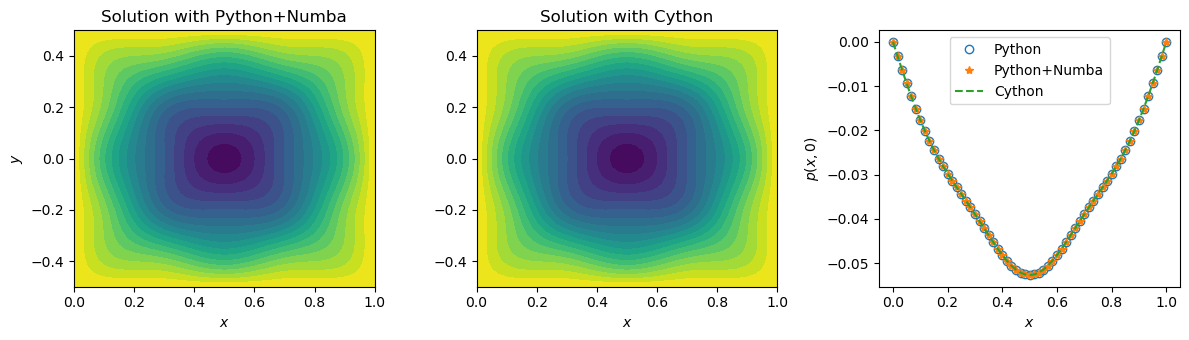

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)

ax[0].contourf(X, Y, nb_p, 20)
ax[1].contourf(X, Y, c_p, 20)

ax[2].plot(x, nb_p[:,jc], 'o', label='Python', markerfacecolor='None')
ax[2].plot(x, nb_p[:,jc], '*', label='Python+Numba')
ax[2].plot(x, c_p[:,jc], '--', label='Cython')

for axis in ax:
    axis.set_xlabel('$x$')

ax[0].set_ylabel('$y$')
ax[2].set_ylabel('$p(x,0)$')

ax[0].set_title('Solution with Python+Numba')
ax[1].set_title('Solution with Cython')

ax[2].legend(loc='upper center');

First of all, both Numba and Cython provide quite a significant speedup. However, the execution time for the Python code with Numba and for Cython differs by almost a factor of $10$? It is in fact caused by *how* Numba is integrated into the Python code in this particular example. If you look into the source code, you'll see that the only piece of code that depends on whether Numba is used or not, is this one:

```
if use_numba:
    pnew = gauss_seidel_step(p, pnew, b, nx, ny, dx)
    diff = norms.l2_diff(pnew, p)
else:
    pnew = py_gauss_seidel_step(p, pnew, b, nx, ny, dx)
    diff = norms.py_l2_diff(pnew, p)
```
This is the only piece of code that will be compiled by Numba. The rest of the code will still be treated by the Python interpreter causing the *interpreter overhead*.

Could this function be implemented otherwise? Yes, it could. The choice has been made deliberately. The thing is that *Numba cannot be used with `tqdm` package*. And even if we have reverted to the standard `print` function, it would have been tricky, as Numba would not allow us to use raw or formatted strings, as well as it doesn't support some of the optional arguments of `print`. We therefore sacrificed some performance for having a fancy logging output. Even though the factor of (almost) $10$ is a significant difference, the time taken by the Python code -partially - compiled with Numba in this particular case is still very little to the human perception.

It is fair to say though that Numba is a very fast evolving package, so we would easily expect the support for `tqdm` to come in some of the future releases.

#### Syntax for Numba integration

Let us now look at how exactly Numba is integrated into the `gauss_seidel_step` function (example of `l2_diff` function is absolutely equivalent):
```
from numba import jit

@jit(nopython=True)
def gauss_seidel_step(p, pnew, b, nx, ny, dx):
    '''Performs one Gauss-Seidel iteration'''
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            pnew[i, j] = (0.25*(pnew[i-1, j] + p[i+1, j] + pnew[i, j-1]
                       + p[i, j+1] - b[i, j]*dx**2))
    return pnew
```
Yes, it is as easy, as it looks. For the majority of problems it would only take decorating your function with a `jit` decorator. The parameter `nopython`, when evaluated to `True`, enables the so-called *nopython* mode. When `nopython` is set to `False`, the *object* mode is enabled. Nopython mode produces higher performance, as it does not use the Python interpreter. Nevertheless it might fail depending on your implementation; compilation will fall back to the object mode only if `nopython` is set to false.

Sometimes you'll also see the notation `@njit`. It is the shortcut to `@jit(nopython=True)`.

#### Minimum on Exception Handling

There is another fragment of the source Python code that must be explained:
```
try:
    from tqdm.auto import tqdm
except ModuleNotFoundError:
    pass
```
This is an example of exceptions handling in Python. Exceptions are mostly errors that occur during the execution. But some of them are warnings or events.

The minimal exception handling block consists of the `try` and `except` clauses. Inside the `try` clause you specify the code that is not exception-safe. `try` clause is not stand-alone and *must* be "accompanied" by the `except` clause. Inside the `except` clause you must specify code that is do be executed if that from the `try` clause fails. If no exceptions occur inside the `try` clause, the `except` clause is skipped. The `pass` statement is used when you want do nothing.

The main purpose of exception handling is making them not fatal.

The example made above perfectly fits this purpose. tqdm, unlike Numba or NumPy, *is not required* for the Gauss-Seidel solver to execute. It is rather a "luxury", not a necessity. We therefore try to import it inside the `try` clause and if the exception of type `ModuleNotFoundError` is raised (tqdm is not found in system), the code doesn't terminate but just proceeds to the further statements.

You can also raise exceptions yourself to prevent and undesired behavior and to provide more informative logging of the code. Inside the `gauss_seidel` function you can see the following lines:
```
if p.shape != b.shape:
    raise ValueError('p and b must have the same shape')
```
As we haven't provided try/except block when calling the function, the `ValueError` exception will be raised and the execution will be terminated if you supply `p` and `b` of different shapes. If you supply `p` and `b` that are not of type `numpy.ndarray`, the execution will crash at the stage when trying to execute the `if` statement with the `AttributeError` being raised.

In a well-designed program, exception handling must provide a certain level of [exception safety][10].

We will not further concentrate on exception handling and will proceed to understanding the Cython implementation of the Gauss-Seidel solver. If you are willing to learn more about exception handling in Python on your own, the good place to start is from the [tutorial provided in the official documentation][11].

#### Cython syntax

If you look into the `csolver.pyx` file, you'll see that there is a bit of unfamiliar syntax. It is not *drastically* different though. Cython syntax builds upon the Python syntax and adds some extra. "Extra" that appeared to be enough to implement the Gauss-Seidel solver consists of ...

* ... type declaration ...

    As it has been mentioned, dynamic typing is the major source for interpreter overhead in Python. In Cython we can use `cdef` statement to declare C variables. In this way Cython won't have to do the type conversion from Python types to C types.

    You can declare and initialize variable at once:
    ```
    cdef int it = 0
    ```
    Or you can declare variable without initialization:
    ```
    cdef Py_ssize_t i, j
    ```
    Note that `Py_ssize_t` is a C type for the indexing.

    As you can see, we also declare types of the objects that we pass to the function:
    ```
    def c_gauss_seidel(<...>, DTYPE_t dx, DTYPE_t tol, int max_it):
        <...>
    ```
    `DTYPE_t` here is just a shortcut we have created for the C type `np.float64_t` that corresponds to the Python type `np.float64` (double precision float):
    ```
    ctypedef np.float64_t DTYPE_t
    ```

    When specifying types of function arguments like this, Python objects are immediately converted into C objects, and `dx`, `tol` and `max_it` are then local C variables.

* ... and Cython memoryviews.

    Cython supports NumPy arrays just as well as Python does. If we looped over NumPy arrays though, it would barely provide any speedup. The reason for that is that `numpy.ndarray` is a Python type and cannot be combined in the same expression with C types. Each time we access elements of `numpy.ndarray`, C integers must be converted to Python integers.

    > [In short, memoryviews][12] are C structures that can hold a pointer to the data of a NumPy array and all the necessary buffer metadata to provide efficient and safe access: dimensions, strides, item size, item type information, etc…

    Syntax to create memoryview from the NumPy array is very simple:
    ```
    cdef np.ndarray[DTYPE_t, ndim=1] tol_hist_gs = np.zeros(max_it, dtype=DTYPE)
    cdef DTYPE_t[:] tol_hist_gs_view = tol_hist_gs
    ```

    Now note how `p` and `b` are passed to the function:
    ```
    def c_gauss_seidel(DTYPE_t[:, :] p, DTYPE_t[:, :] b,
                   DTYPE_t dx, DTYPE_t tol, int max_it):
        <...>
    ```
    This way, when we originally pass the object of type `numpy.ndarray`, their memoryviews are created right away and can be accessed through the variables `p` and `b`.

    NumPy array that is pointed to by the memoryview can be accessed through the `base` attribute of the memoryview:
    ```
    return <...>, p.base, <...>
    ```

    It is due to the reason that we use memoryvies in the main loop of the program, that we gain such a speedup:
    ```
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            p_new_view[i, j] = (0.25*(p_new_view[i-1, j] + p[i+1, j]
                + p_new_view[i, j-1] + p[i, j+1] - b[i, j]*dx**2))
    ```
    Note that as well as for the most of the rest of code, syntax for the loops in Cython is exactly that of Python.

    The downside we get when using memoryviews is that they are not as flexible as Numpy arrays. Many NumPy functions though still support memoryviews. Memoryviews even support some of the "same" methods and attributes that Numpy arrays do but the return values are always of the C type.

Generally almost *any* Python code is valid in Cython. This is no surprise, as aside from when working with C types directly, Cython makes calls to the Python interpreter. We have introduced typing and memoryvies as an extra of Cython to gain the speedup but the pure Python code should also compile.

As it has been said, learning to program efficiently in Cython should not be a complicated task for the Python programmer. Nevertheless, aside from writing the source code, it is also necessary to provide proper compile instructions (makefile). The makefile used in this demo is trivial:
```
from setuptools import setup
from Cython.Build import cythonize
import numpy

setup(
    ext_modules=cythonize('csolver.pyx',
                        build_dir='build',
                        annotate=True,
                        language_level = '3'),
    include_dirs=[numpy.get_include()],
)
```
`Cython.Build.cythonize` function is responsible for that the source Cython file (`csolver.pyx` in this case) is compiled into C code that is further compiled into machine code, and the shared library is created. The latter is directly importable into Python code, as we have showed above. `build_dir` parameter specifies the location where the files created at compile time are stored. `language_level` specifies the standard of Python that is used.

The line
```
include_dirs=[numpy.get_include()]
```
is important to our code because we have imported the *definition* numpy file using `cimport` command:
```
cimport numpy as np
```

Definition file is the Cython analogy to the C header file. We needed numpy definition file for the C type `np.float64_t`.

To run the Cython makefile, the following command must be executed:
```
python setup.py build_ext --build-lib <target_dir>
```
where the `<target_dir>` specifies the location for the shared library.

Overall, as you see, there is much more information to absorb when understanding Cython than when understanding Numba. Numba should certainly be your first choice when it is easily integratable. Cython though communicates much more naturally with C (and C++) code.

[10]: <https://en.wikipedia.org/wiki/Exception_safety> "Exception safety"
[11]: <https://docs.python.org/3/tutorial/errors.html> "Exception handling"
[12]: <https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#efficient-indexing-with-memoryviews> "Memoryviews"

## Summary

In this notebook we have dug deeper into the basic programming concepts, such as compilers and interpreters. We have investigated alternative tools to get C-like performance with Python - Numba and Cython. The sample implementation of Gauss-Seidel solver has been sped up by the factor of about $20$ with Numba and $100$ with Cython. It is important to note though that generally Numba and Cython show similar performance for the same kind of problems. We chose to implement partial compilation with Numba in order to use the logging tools of tqdm package. Python decorators and exception handling were introduced as a part of the tutorial.
We therefore conclude the chapter on iterative methods with numerical tools for efficient implementation of iterative solvers.